# Matches & SNR with Python Model using nrutils clone of MMA match function (LL17)

## Notes:
* Developement of a lal independent match is accomplished
* Testing of the leading quadrupole seems to verify py 22-olny recovery of phenomd; more testing needed 
* LAL version of PhnenomHM incorporated; more testing needed 
* comparison of py version of model to mma version appears to reveal inconsistent handling of leading order amplitude; verify
* !!! MMA and nrutils differ in the sign of $\phi$ -- this does NOT affect matches
* ARE M<0 MULTIPOLES HANDELED CORRECTLY BY LALPHENOMHM &/OR its WRAPPER ??????? -- if not, it may explain why doubles sided matches suck, and positive sided ones are good exept at edge on???

## Strategy: Develope match class

* Sections below independently test class methods
* Compine methods as needed for more advanced calculations 
* Keep development sections as "unit tests"

## Setup ipython environment
* Import maths, plotting, other low level packs
* Import nrutils for handling simulations and waveform data
* Import nrutils.analysis.match for match class development

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
#
from positive import *
#
from numpy import *
from numpy.fft import ifft,fftshift,fftfreq,fft
from glob import glob as find
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
from nrutils.core.basics import *
from nrutils import scsearch,gwylm,physf,physhf
from nrutils.analyze.match import match as match_object
#
from lalsimulation import SimInspiralChooseFDWaveform
import lalsimulation as lalsim
#
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2), (3, 3)] coprecessing moment multipole moment(s)


## Find an NR Simulation

In [2]:
%time
# bam_id = 'q8a0a0_T_112_588n768'
# sce = scsearch(keyword=bam_id,verbose=True)[-1]

# bam_id = 'q4a0_T_112_448'
# sce = scsearch(keyword=bam_id,verbose=True)[-1]

# sce = scsearch(institute='sxs',q=4,nonspinning=True,verbose=True)[-1]

# sce = scsearch(q=18,,verbose=True)[-1]

# bam_id = 'q18a0aM04c025_96_fine'
# sce = scsearch(keyword=bam_id,verbose=True)[-1]

bam_id = 'q8a06t120'
sce = scsearch(keyword=bam_id,verbose=True,catalog=calibration_catalog)[-1]

# --~-~--~-~--~-~--~-~--~-~--~-~ #
#         FOR THE PAPER          #
# --~-~--~-~--~-~--~-~--~-~--~-~ #


# bam_id = 'q4a05_T_96_384'
# sce = scsearch(keyword=bam_id,verbose=True)[-1]

# bam_id = 'q2_-0.5_-0.5_96_460'
# sce = scsearch(keyword=bam_id,verbose=True)[-1]


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q8a06t120) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 1 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.60-p-q8.00	(q8a06t120dP2_T_96_384)



## Load the NR data

In [4]:
# Load the NR data

## Load only the select modes of interest
y = gwylm(sce,lmax=3,clean=True,verbose=not True,dt=0.5)

# Load all of modes in the NR data
# y = gwylm(sce,lmax=5,clean=True,verbose=True, dt=0.5 )

# select_lm = [(2,2),(2,-2)]
# select_lm = [(2,2),(2,1),(2,-1),(2,-2)]
select_lm = y.__input_lmlist__

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(__calc_radiated_linear_momentum__!)>> The current objects max ell value is 3, but we recommend a value of at least 4 for accurate determination of radiated linear momentum.


([<AxesSubplot:ylabel='$r\\,h(t,\\theta,\\phi)/M$'>,
  <AxesSubplot:ylabel='$\\phi = \\mathrm{arg}(r\\,h(t,\\theta,\\phi)/M)$'>,
  <AxesSubplot:ylabel='$\\mathrm{d}{\\phi}/\\mathrm{d}t$'>,
  <AxesSubplot:xlabel='$t$', ylabel='$\\mathrm{d}^2{\\phi}/\\mathrm{d}t^2$'>],
 <Figure size 633.6x760.32 with 4 Axes>)

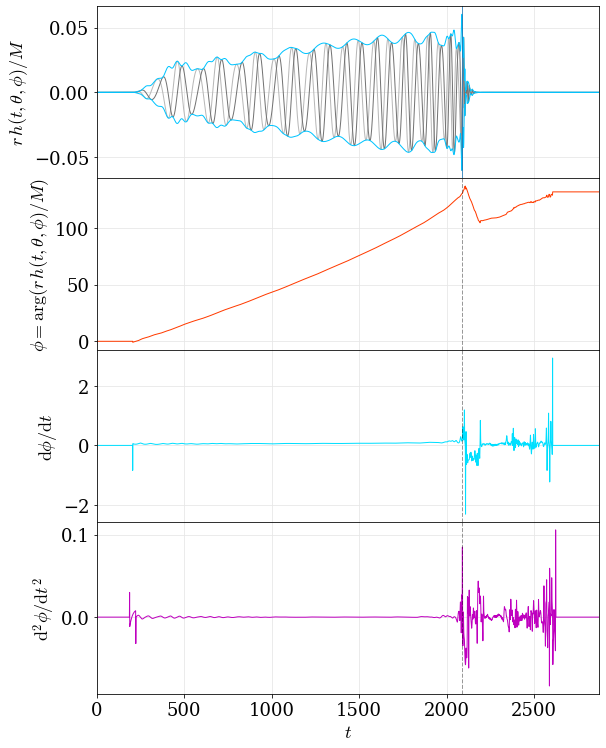

In [16]:
# y.plot(kind='strain',domain='time',show=True)
# y.plot(kind='strain',domain='freq',show=True)

s = y.recompose( pi, 0, select_lm=None,kind='strain',output_array=not True,domain='freq')
s.plot(domain='time')

# savetxt( '/Users/book/Desktop/nr_edge_on.asc', vstack([s.f,s.fd_y.real,s.fd_y.imag]).T )
# savetxt( '/Users/book/Desktop/phenomhm_edge_on.asc', vstack([s.f,s.fd_y.real,s.fd_y.imag]).T )

## Generate an instance of PhenomHM (this is not the LAL version, and is possibly not used below)
* python or LALSim versions both called through same interface
* see PhenomHM repo for related package
* the class is phenom_hm:
  * version 1 -- the model agnostic PhenomHM method
  * version 2 -- the python implementation of the PhenomD extension
  * version 3 -- the lalsim implementation of the PhenomD extension (NOT YET IMPLEMENTED IN CLASS; must call lal through lalphenomhm in core.py)

In [9]:
%time
# Generate an instance of PhenomHM (python version)
z = phenom_hm(gwylmo=y,verbose=True,lm=[(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)],__tuning__=False,version=2)
# NOTE that version=2 uses the modified phenomD phase ansatz, while version=1 is the phenomD independent map

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
(phenom_hm)>> Using partially external mapping -- the phase function will be changed and a scaling map will be applied post-ringdown frequency
(__set_lmlist__)>> Setting list of l and m to consider based on lm and/or lmax inputs.
(__set_lmlist__)>> The following spherical multipoles will be generated:[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3)]
(__set_splines__)>> Calling the underlying model (Sebastians github PhenomD) once, and then creating a spline representation for use in mapping.
(__set_cw__)>> Loading and storing relevant QNM frequencies and decay times.
(__lmeval__)>> Evaluating phenom_hm for (2, 2) ...
(__lmeval__)>> Evaluating phenom_hm for (2, 1) ...
(__lmeval__)>> Evaluating phenom_hm for (3, 3) ...
(__lmeval__)>> Evaluating phenom_hm for (3, 2) ...
(__lmeval__)>> Evaluating phenom_hm for (4, 4) ...
(__lmeval__)>> Evaluating phenom_hm for (4, 3) ...
(__set_td__)>> Calculating time domain waveforms.
(__init

## Prepare data for match calculation, and generate match_object

In [10]:
# Parameters 
theta = pi/2 # 0.99*pi/2 # 0.5*pi
phi = 0
M = 90 # Solar Masses # 90 Msolar was used in the PE run
D = 550 # Mpc
# Minimum fmin from NR waveform + 10Hz padding
nr_fmin = physf( y.wstart_pn/(2*pi), M ) + 10.0
fmin = 20 # 20 is used in the PE run 
print '>> NR Fmin = %f' % nr_fmin
print '>> Using Fmin = %f' % fmin
fmax = 300
df = physf(y.ylm[0].df,M)
print 'physical_df = ',df

>> NR Fmin = 27.763996
>> Using Fmin = 20.000000
physical_df =  1.36393496525


In [11]:
# #
# nrpath = '/Users/book/tmp/q8a0a0_T_112_588n768_fix_scale.h5'
# nrdict = get_nr_dict( nrpath )

# #
# delta_F = 0.86
# buffer_fact = 1.0
# nrpars = make_siminspiralFD_params(m1=nrdict['m1'], m2=nrdict['m2'], s1x=nrdict['s1x'], s1y=nrdict['s1y'], s1z=nrdict['s1z'],
#                       s2x=nrdict['s2x'], s2y=nrdict['s2y'], s2z=nrdict['s2z'], distance=nrdict['distance'], inc=0., phiref=0.,
#                           delta_F=delta_F, buffer_fact=buffer_fact, fmin=nrdict['fmin'], fmax=fmax, fref=nrdict['fref'],
#                           approx=nrdict['approx'], waveFlags=nrdict['waveFlags'])

# print nrpars
# NR_signal = lalsim.SimInspiralFD(**nrpars)


/Library/Python/2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Library/Python/2.7/site-packages/matplotlib/transforms.py:988: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


(439, 3) (439, 3)


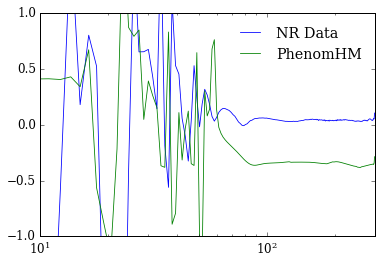

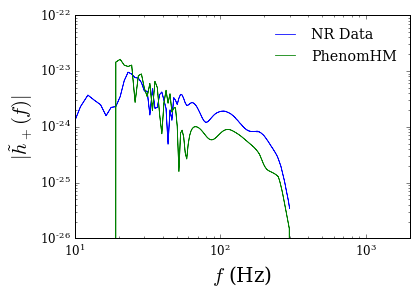

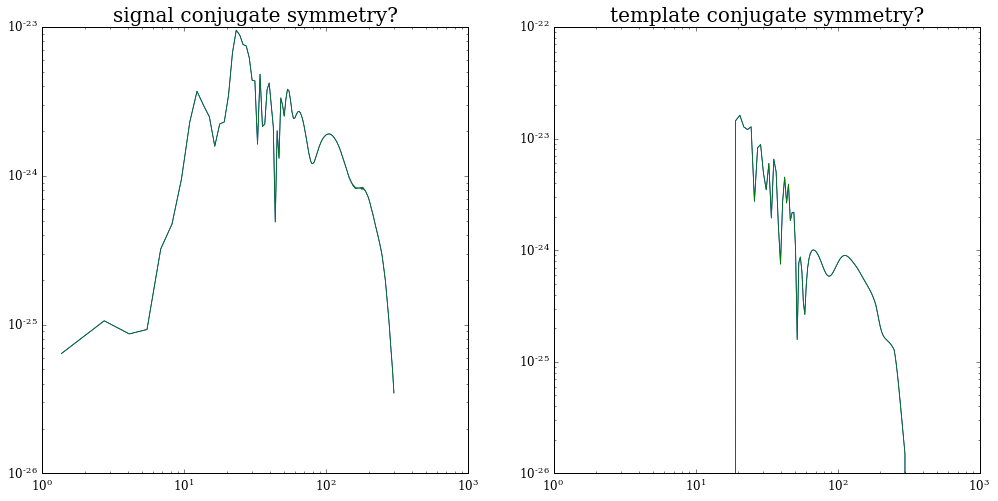

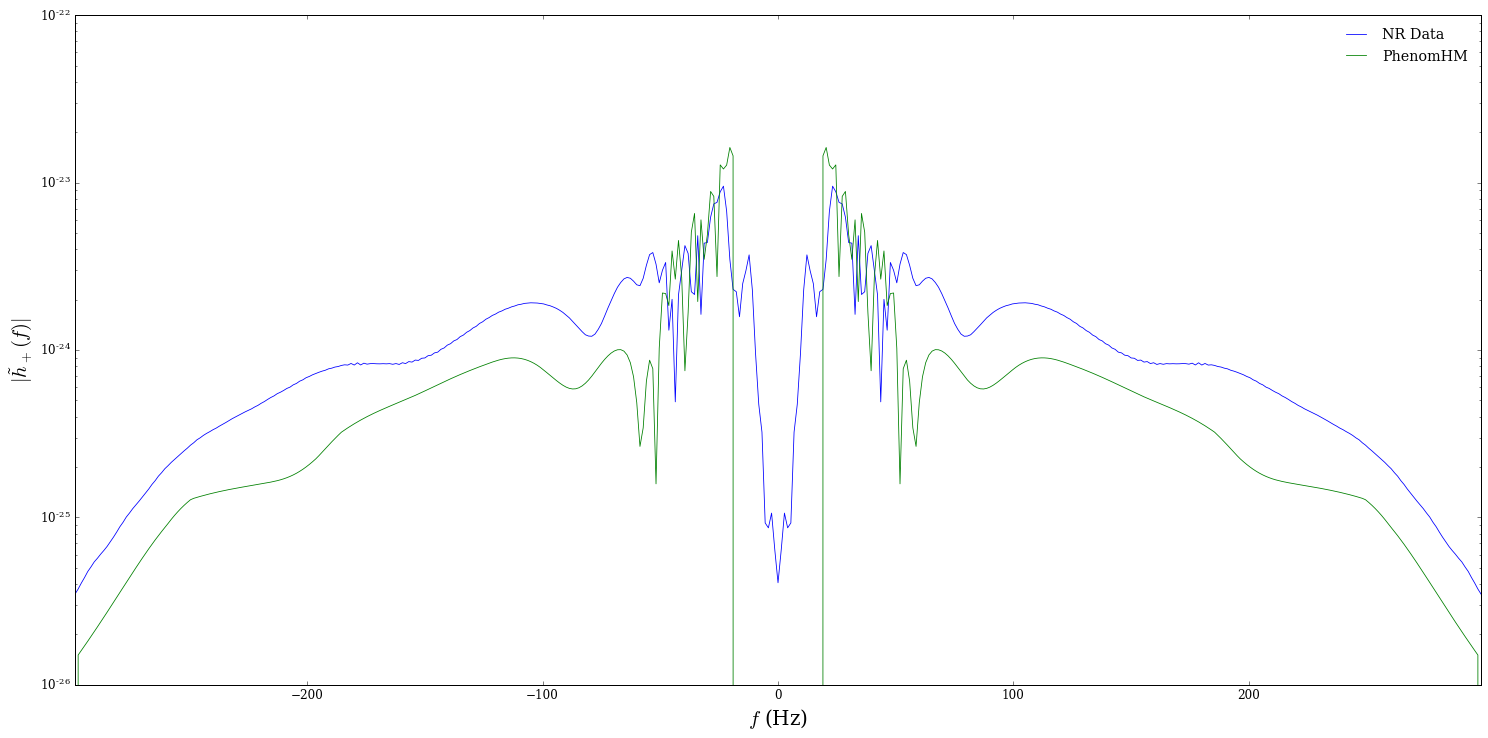

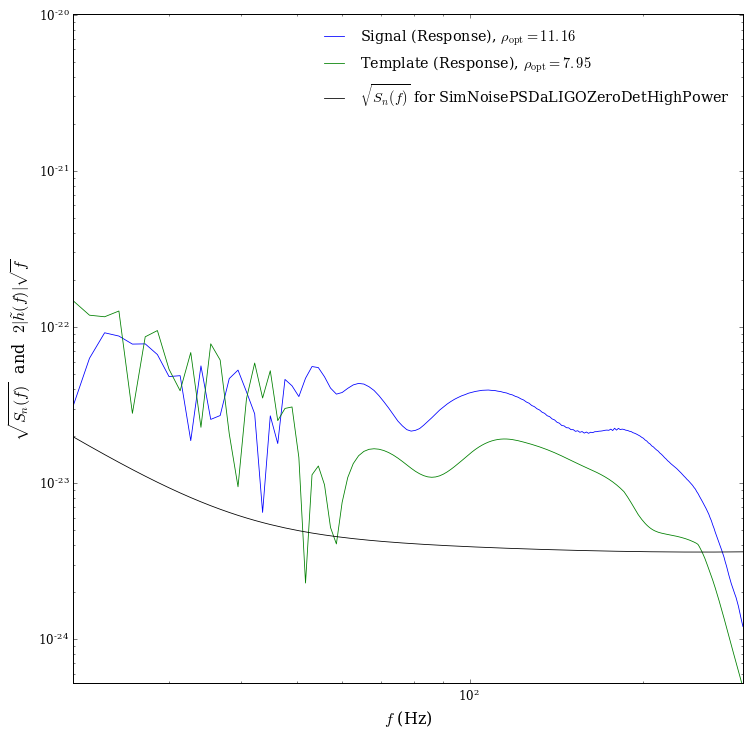

In [12]:
# Prepare data for match calculation




#--%--%--%--%--%--%--%--%--%--%--%--#
# Define high-level waveform functions
#--%--%--%--%--%--%--%--%--%--%--%--#

def signal_wfarr_fun( THETA,PHI,LM=None) : 
    # USE ALL NR MODES
    ans = physhf( y.recompose( THETA,PHI, select_lm=y.__lmlist__,kind='strain',domain='freq').fd_wfarr, M, D ) 
    #     ans = physhf( y.recompose( THETA,PHI, select_lm=select_lm,kind='strain',output_array=True,domain='freq'), M, D ) 
    return ans
def template_wfarr_fun( THETA,PHI,LM=None) : 
    if LM is None: LM = []
    if set(LM) == set([(2,2),(2,-2)]):
        ans = lalphenomhm( y.eta,M,y.X1[-1],y.X2[-1],THETA,PHI,D,df,fmin,fmax, approx='IMRPhenomD' )
    else:
        ans = lalphenomhm( y.eta,M,y.X1[-1],y.X2[-1],THETA,PHI,D,df,fmin,fmax )
    return ans

#--%--%--%--%--%--%--%--%--%--%--%--#
# Construct model and NR waveform at a fixed inclination and 
#--%--%--%--%--%--%--%--%--%--%--%--#



phys_template = template_wfarr_fun( theta, phi )
phys_signal = signal_wfarr_fun( theta,phi-pi/2 )
# phys_template = lalphenomhm(y.eta,M,y.X1[-1],y.X2[-1],theta,phi,D,df,fmin,fmax)
# phys_signal   = physhf( y.recompose(theta,2.2847,select_lm=select_lm,kind='strain',output_array=True,domain='freq') , M, D )  # waveform array (wfarr) with columns [frequency plus cross]

# preformat for plotting
mask = abs(phys_signal[:,0]) <= fmax
phys_signal = phys_signal[mask,:]
mask = abs(phys_template[:,0]) <= fmax
phys_template = phys_template[mask,:]

figure()

f = phys_template[:,0].real
d1 = spline_diff(f,unwrap(angle(phys_template[:,1])))
d2 = spline_diff(f,unwrap(angle(phys_signal[:,1] )))

k = (abs(f) <= 20+fmax) & (abs(f) > fmin)
plot( f, d2 - average(d2[k],weights=abs(phys_signal[k,1])), label='NR Data' )
plot( f, d1 - average(d1[k],weights=abs(phys_template[k,1])), label='PhenomHM' )
legend(frameon=False)
ylim([-1,1])
xlim([fmin/2,fmax])
xscale('log')

# print phys_template.shape, diff( phys_template[:,0] )[0], phys_template[0,0]
# print phys_signal.shape, diff( phys_signal[:,0] )[0], phys_signal[0,0]

# raise

figure()
k = 1
plot( abs(phys_signal[:,0]), abs(phys_signal[:,k]), label='NR Data' )
plot( abs(phys_template[:,0]), abs(phys_template[:,k]), label='PhenomHM' )
# ylim([1e-4,1e2])
xlim([10,2e3])
legend(frameon=False)
yscale('log'); xscale('log')
xlabel(r'$f$ (Hz)')
ylabel(r'$|\tilde{h}_+(f)|$')

#--~--~--~--~--~--~--~--~--~-~-~-~~~vvvvvvvvvwwVw>~~~~~#

figure( figsize = 4*array([4.2,2] ) )

#=====================#
j = phys_signal[:,0]>0
k = phys_signal[:,0]<0
#=====================#
subplot(1,2,1)
title('signal conjugate symmetry?')
# print allclose( phys_signal[:,1].real, phys_signal[:,2][::-1].conj().real, rtol=1e-10 )
plot( phys_signal[j,0], abs(phys_signal[j,1]) )
plot(-phys_signal[k,0], abs(phys_signal[k,1].conj()), '-' )
# plot( phys_signal[j,0], abs(phys_signal[j,2]), 'r--' )
# plot( phys_signal[j,0], abs(phys_signal[k,2][::-1].conj()), 'k:' )
xscale('log')
yscale('log')

#=====================#
j = phys_template[:,0]>0
k = phys_template[:,0]<0
#=====================#
subplot(1,2,2)
title('template conjugate symmetry?')
# print allclose( phys_signal[:,1].real, phys_signal[:,2][::-1].conj().real, rtol=1e-10 )
plot( phys_template[j,0], abs(phys_template[j,1]) )
plot( -phys_template[k,0], abs(phys_template[k,1].conj()), '-' )
# plot( phys_template[j,0], abs(phys_template[j,2]), 'r--' )
# plot( phys_template[j,0], abs(phys_template[k,2][::-1].conj()), 'k:' )
xscale('log')
yscale('log')
#--~--~--~--~--~--~--~--~--~-~-~-~~~vvvvvvvvvwwVw>~~~~~#

# fmask = (abs(phys_signal[:,0])>=fmin) & (abs(phys_signal[:,0])<=fmax)
# phys_template = phys_template[fmask,:]
# phys_signal = phys_signal[fmask,:]

figure( figsize = 6*array([4.2,2] ) )
k = 1 # toggle for plus or cross
plot( phys_signal[:,0].real, abs(phys_signal[:,k]), label='NR Data' )
plot( phys_template[:,0].real, abs(phys_template[:,k]), label='PhenomHM'  )
# ylim([1e-28,1e-21])
xlim(max(phys_signal[:,0])*array([-1,1]).real)
yscale('log')
# xscale('log')
xlabel(r'$f$ (Hz)')
ylabel(r'$|\tilde{h}_+(f)|$')
legend(frameon=False)

# print max(abs(phys_template[:,1]))

#--%--%--%--%--%--%--%--%--%--%--%--#
# Construct match object
#--%--%--%--%--%--%--%--%--%--%--%--#

print phys_template.shape, phys_signal.shape

# mo = match_object( phys_signal, phys_signal, psd_name='aligo',fmin=40 )
mo = match_object( phys_template, phys_signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
mo.plot()

#### Calculate AB's match with plotting

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


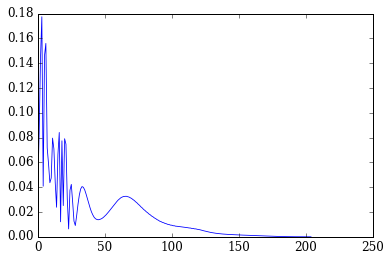

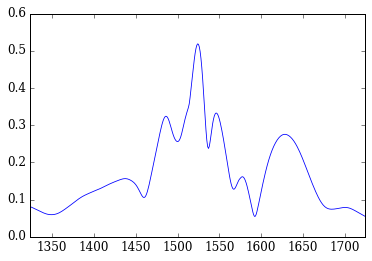


>> Results of intrp_max:
----------------------------------------
    intrp_max 	 = 	 0.518815
intrp_arg_max 	 = 	 1524.286578



/Library/Python/2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:
/Library/Python/2.7/site-packages/matplotlib/lines.py:1082: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markeredgecolor != ec:


0.51860147209629937

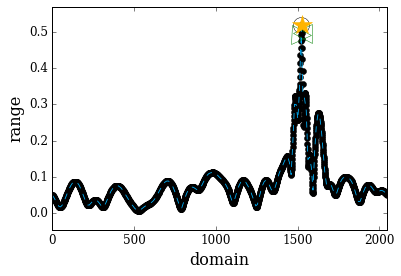

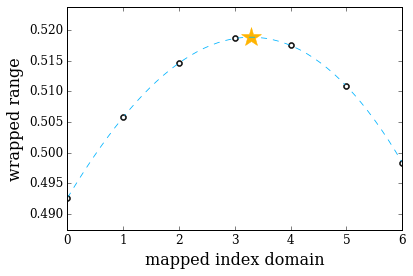

In [13]:
%time
mo.calc_template_pol_optimized_match( plot=True )




## Inspect effect of template polarization and verify that all methods for optizing over this agree

(0.51377381591492399, 0.51904034993096981)
Optimization over template polarization
----------------------------------------
coarse:		0.51421269375
brute force:	0.51421269375
analytic:	0.518601472096


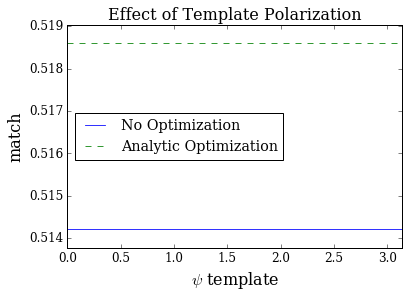

In [14]:
# h_template = cos(2*psi)*hp + sin(2*psi)*hx
psirange = linspace(0,pi,53)
matchlist = []
vanilla = []
for psi in psirange:
    matchlist.append( mo.calc_basic_match(template_polarization=psi) )
    vanilla.append( mo.calc_template_pol_optimized_match() )
matchlist = array(matchlist)
vanilla = array(vanilla)
plot( psirange, matchlist, '-', label='No Optimization' )
plot( psirange, vanilla, '--', label='Analytic Optimization' )

xlabel(r'$\psi$ template')
ylabel('match')
title('Effect of Template Polarization')
legend( frameon=not False, loc=6 )

analytic_value =  mo.calc_template_pol_optimized_match()

codomain = array( list(matchlist)+[analytic_value] )
dy = diff(lim( codomain ))*0.1
print ylim( lim(codomain ) + dy*array([-1,1]) )
xlim( lim(psirange) )

print 'Optimization over template polarization\n%s'%(20*'--')
print 'coarse:\t\t',max(matchlist)
print 'brute force:\t',mo.brute_match()
print 'analytic:\t',analytic_value

## Effect of orbital phase of model (template) on match at fixed Signal polarization


Result of notebook for-loop method:
----------------------------------------


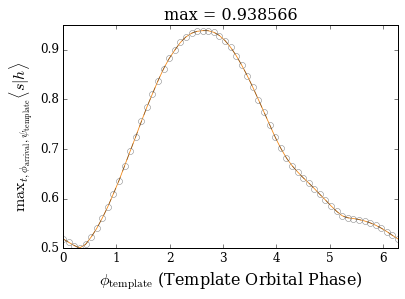


Result of class method:
----------------------------------------
NOTE: This method uses intrp_max to get a better peak location.


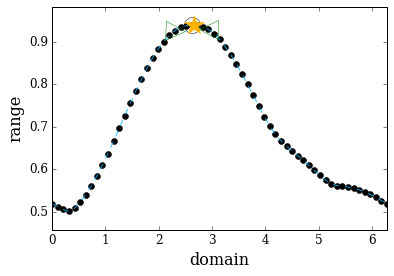

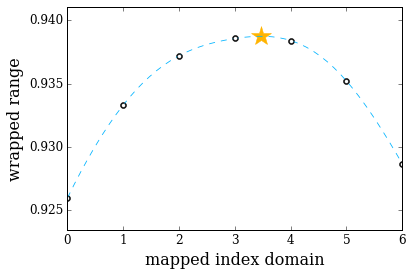

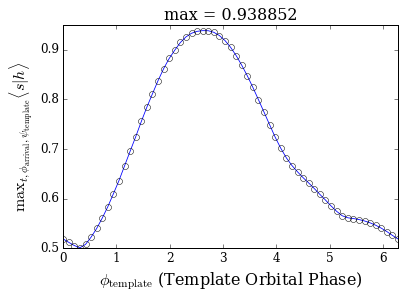

In [15]:
# Optimize match over orbital phase of model (template)

figure()
    
phi_range = linspace(0,2*pi,61)
# print 'yo! --> ',physf(y.ylm[0].df,M)
# template_wfarr_fun = lambda PHI: physhf( z.recompose(theta, PHI, select_lm=select_lm), M, D ) 
template_phi_wfarr_fun = lambda PHI: template_wfarr_fun( theta, PHI )
# template_phi_wfarr_fun = lambda PHI: lalphenomhm( y.eta,M,y.X1[-1],y.X2[-1],theta,PHI,D,phys_df,fmin,fmax )


# 
matchlist = []
for phi in phi_range:
    # 
    mo.apply( template_wfarr = template_phi_wfarr_fun(phi) )
    matchlist.append(  mo.calc_template_pol_optimized_match() )

#
print '\nResult of notebook for-loop method:\n%s'%(20*'--')

plot( phi_range, matchlist, marker='o', color='#f48713', mfc='none', mec=0.5*ones(3) )
phi_ = linspace(0,2*pi,2e2)
plot( phi_, spline(phi_range,matchlist)(phi_), '--k', alpha=0.4 )
    
xlabel(r'$\phi_{\mathrm{template}}$ (Template Orbital Phase)')
xlim(lim(phi_))
# title('$\psi_{\mathrm{signal}} = %1.2f$'%mo.signal['polarization'])
ylabel(r'$ \operatorname{max}_{t,\phi_{\mathrm{arrival}},\psi_{\mathrm{template}}} \langle s | h \rangle$')
title('max = %f'%max(matchlist) )
# title(r'Optimized over $\psi_{\mathrm{template}}$')
show()

print '\nResult of class method:\n%s\nNOTE: This method uses intrp_max to get a better peak location.'%(20*'--')
mo.calc_template_phi_optimized_match(template_phi_wfarr_fun,plot=True);

## Effect of signal polarization on match

**Notes:**
 * For a range of parameter values, the match as a sunction of signal polarization displays sharp dips at specific parameter values
 * This effect is "corrected" by detecting of psi is in $(\pi/4,3\pi/4)$ and then shoifting it by some very small number
 * The result still shows a small but acceptable pathology

Match Statistics:
----------------------------------------
avg =  0.938852080873
min =  0.938852080872
max =  0.938852080881


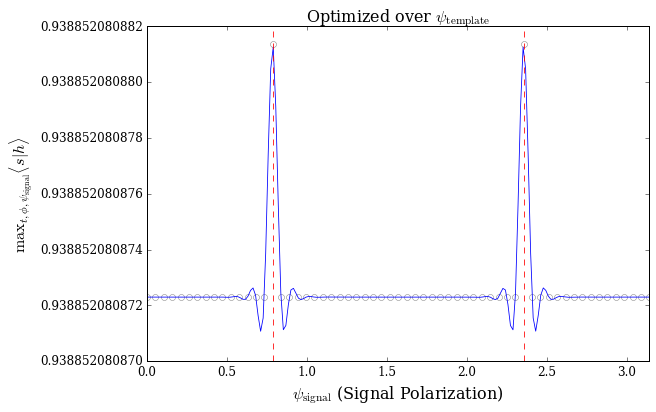

In [16]:
sprange = linspace(0,pi,61)
splist = array( map( lambda sp: mo.calc_template_pol_optimized_match( signal_polarization = sp ), sprange ) )

figure( figsize = 1.5*array([6,4]) )
plot( sprange, splist, 'o', mfc='none', mec=0.5*ones(3) )
spo_ = linspace(0,pi,2e2)
plot( spo_, spline(sprange,splist)(spo_), '-b' )

axvline( pi/4, color='r', linestyle='--' )
axvline( 3*pi/4, color='r', linestyle='--' )

xlabel(r'$\psi_{\mathrm{signal}}$ (Signal Polarization)')
xlim(lim(spo_))
# ylim([min(ylim()),1])

ylabel(r'$ \operatorname{max}_{t,\phi,\psi_{\mathrm{signal}}} \langle s | h \rangle$')
title(r'Optimized over $\psi_{\mathrm{template}}$')

print 'Match Statistics:\n%s'%('--'*20)
print 'avg = ',mean(splist)
print 'min = ',min(splist)
print 'max = ',max(splist)

## Effect of Signal Polarization on Signal Optimal SNR

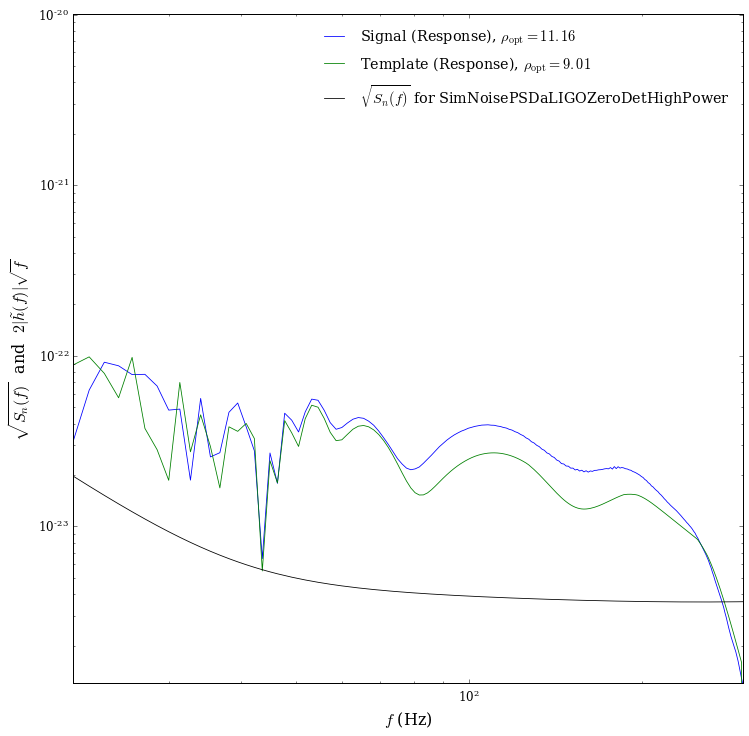

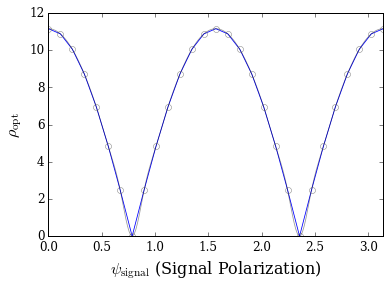

In [17]:
sprange = linspace(0,pi,29)
def spf(sp):
    return mo.apply( signal_polarization = sp ).signal['optimal_snr']
splist = array( map( spf, sprange ) )
mo.plot()
figure()
plot( sprange, splist, marker='o', mfc='none', mec=0.5*ones(3) )
spo_ = linspace(0,pi,2e2)
plot( spo_, spline(sprange,splist)(spo_), '-k', alpha=0.4 )
xlabel(r'$\psi_{\mathrm{signal}}$ (Signal Polarization)')
xlim(lim(spo_))
# ylim([min(ylim()),1])
ylabel(r'$\rho_{\mathrm{opt}}$')

## Investigate Sky Moments at Edge On

In [18]:
#
# %time
# match_info = mo.calc_match_sky_moments( signal_wfarr_fun,
#                                         template_wfarr_fun, 
#                                         N_theta = 1, 
#                                         N_psi_signal = 17, 
#                                         N_phi_signal = 12,
#                                         plot = True,
#                                         hm_vs_quad = True,
#                                         verbose = True )

## Perform matches over the sky and calculate statistics

In [20]:
%time
# error('task -- modify gwylm.recompose to optionally act oly on fd arays and ooutput correct + and x columns; ')
# signal_wfarr_fun =   lambda THETA,PHI,LM=None: physhf( y.recompose( THETA,PHI, select_lm=select_lm,kind='strain',output_array=True,domain='freq'), M, D ) 
# template_wfarr_fun = lambda THETA,PHI,LM=None: physhf( z.recompose( THETA,PHI, select_lm=select_lm), M, D ) 
# template_wfarr_fun = lambda THETA,PHI,LM=None: lalphenomhm( y.eta,M,y.X1[-1],y.X2[-1],THETA,PHI,D,phys_df,fmin,fmax )

# error('''There's a discrepance between the resultrs of the above section on optimizing over template phi, and the results below. FIGURE OUT WHY! ''')

match_info = mo.calc_match_sky_moments( signal_wfarr_fun,
                                        template_wfarr_fun, 
                                        N_theta = 21, 
                                        N_psi_signal = 8, 
                                        N_phi_signal = 11,
                                        hm_vs_quad = True,
                                        verbose = True )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
 (calc_match_sky_moments)>> We will also compute matches for the quadrupole only template.
(calc_match_sky_moments)>> theta = 0.01
----------------------------------------
>> working  . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . ,  done.
>>  min_match 	 = 	 0.974556
>>  avg_match 	 = 	 0.975141
snr_avg_match 	 = 	 0.975141
>>  max_match 	 = 	 0.975769
##  quadrupole_min_match 	 = 	 0.973152
##  quadrupole_avg_match 	 = 	 0.974033
quadrupole_snr_avg_match 	 = 	 0.974035
##  quadrupole_max_match 	 = 	 0.974914
----------------------------------------
(calc_match_sky_moments)>> theta = 0.17
----------------------------------------
>> working  . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . .

### Make simple plots and store match data

(mkdir)>> Directory at "/Users/book/Desktop/q18a0aM08c025_96_fine/data/" already exists and will be not be altered or created..
[ 0.00070769  0.00097707]
/Users/book/GARREG/REPOS/PhenomHM/workflows/matches/python/all_py_matches.ipynb


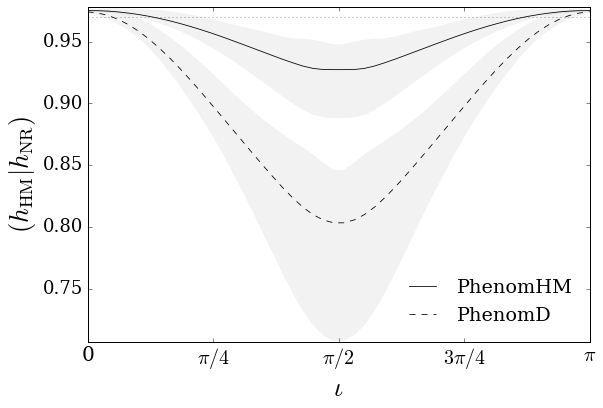

In [23]:
import pickle

#
outdir = '/Users/book/Desktop/'+sce.simname+'/'
datadir = outdir + 'data/'
mkdir(datadir,verbose=True)

#
filepath = datadir + 'match_info.pickle'


# with open( '/Users/book/GARREG/REPOS/PhenomHM/workflows/matches/data/q2_-0.5_-0.5_96_460/data/match_info.pickle' , 'rb') as datafile:
#     match_info = pickle.load( datafile )

#
with open(filepath, 'wb') as datafile:
    pickle.dump( match_info , datafile, pickle.HIGHEST_PROTOCOL )

# #
# for k in match_info:
#     savetxt( datadir+k+'.asc', match_info[k] )
    

# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['axes.titlesize'] = 20    
    
a = match_info

figure( figsize = 6*array([1.5,1]) )

# #
# alpha = 0.06
# fill_between( a['theta'], a['min'], a['max'], color='k', alpha=alpha, edgecolor='none' )
# fill_between( a['theta'], a['quadrupole_min'], a['quadrupole_max'], color='k', alpha=alpha, edgecolor='none' )
# plot( a['theta'], a['weighted_avg'],'-k',label='PhenomHM' )
# plot( a['theta'], a['quadrupole_weighted_avg'],'--k',label='PhenomD' )

#
alpha = 0.05
sth = linspace(0,pi)
sm = lambda x: spline( a['theta'], a[x], k=2 )(sth)
fill_between( sth, sm('min'), sm('max'), color='k', alpha=alpha, edgecolor='none' )
fill_between( sth, sm('quadrupole_min'), sm('quadrupole_max'), color='k', alpha=alpha, edgecolor='none' )
plot( sth, sm('weighted_avg'),'-k',label='PhenomHM' )
plot( sth, sm('quadrupole_weighted_avg'),'--k',label='PhenomD' )
# plot( sth, sm('quadrupole_weighted_avg'),'--k',label='$(l,m)=(2,\pm 2)$ Model' )


#
hline = [0.97,0.98,0.99,1.0]
for val in hline:
    axhline(val,linestyle=':',color='k',alpha=0.5)

#
xlim([0,pi])
legend( frameon=False, loc=4 )
    
#
xtk_labels =    [ '0',  r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$' ]
xtk = pi*array( [  0,   1.0/4,      1.0/2,      3.0/4,       1  ] )
xticks(xtk,xtk_labels)
gca().tick_params(axis='y', which='major', labelsize=18)
gca().tick_params(axis='x', which='major', labelsize=20)
    
xlim( [0,pi] )
xlabel(r'$\iota$')
# ylabel(r'$ \operatorname{max}_{t,\phi_{\mathrm{arrival}},\psi_{\mathrm{template}}} \langle s | h \rangle$')
ylabel(r'$( h_\mathrm{HM} | h_\mathrm{NR} )$')

# gca().yaxis.set_label_position("right")
# gca().yaxis.tick_right()

yl = lim( hstack([sm('quadrupole_min'),sm('max')]) )
dy = 0.001*yl
print dy
ylim( yl + dy*array([-1,1]) )

# title(y.simname)

savefig( outdir+'matches_'+sce.simname+'_ALL_NR_MULTIPOLES.pdf' )

#
from shutil import copyfile
src = '/Users/book'+NOTEBOOK_FULL_PATH
print src
dst = outdir + 'notebook_used_for_%s.ipynb'%sce.simname
# copyfile(src, dst)


['theta', 'phi_signal', 'optsnr', 'match', 'psi_signal']
0.954457659774
0.964761343443


(array([  14.,   18.,   20.,   14.,   16.,   36.,   42.,   48.,   66.,
          88.,   62.,   96.,  108.,  112.,  116.,  122.,   96.,  152.,
         168.,  454.]),
 array([  1.70302209,   2.39710879,   3.09119549,   3.78528219,
          4.47936889,   5.17345559,   5.86754229,   6.56162899,
          7.25571569,   7.94980239,   8.64388909,   9.33797579,
         10.03206249,  10.72614919,  11.42023589,  12.11432259,
         12.80840929,  13.50249599,  14.19658269,  14.89066939,  15.58475609]),
 <a list of 20 Patch objects>)

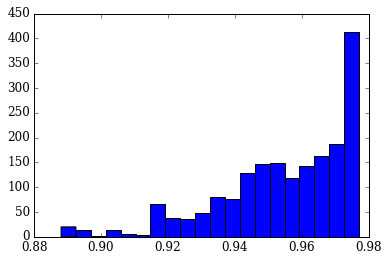

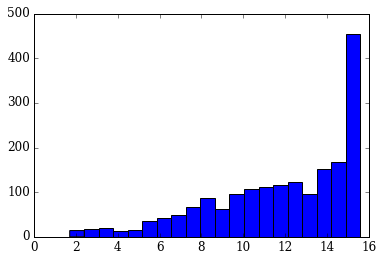

In [38]:
samples = match_info['samples']
print samples.keys()
hist( samples['match'], 20 )
print average( samples['match'] )
print average( samples['match'], weights=array(samples['optsnr'])**3 )

figure()
hist( samples['optsnr'], 20 )

In [ ]:
If I were new 
If you could see
the truth in me 
beyond my face 
beyodn this shell
beyond-yond 
all of the 
lies
that they have told to us
all our lives